**IEM Closure of $f_B$ in 1D**

Following [Pope et al. 1985](https://www.sciencedirect.com/science/article/abs/pii/0360128585900024) the evolution equation for these distributions is given by

\begin{equation}
\frac{\partial f_B}{\partial t} = -\frac{\partial }{\partial b} \left( \mathbb{E}_B[ \alpha \nabla^2 B ] f_B \right).
\end{equation}

As $f_B(b,t)$ contains no information about space this equation is unclosed as the conditional expectation is unknown, however we can apply the IEM closure developed by (Dopazo, C. & O'Brien, E. 1974) and discussed by (Pope, S.B. 2010) to estimate a closure for the molecular mixing terms. This closure takes the form

\begin{equation}
    \mathbb{E}_B[ \alpha \nabla^2 B ] = - \frac{\omega_B}{2}  \left( b - \mathbb{E}[B] \right),
\end{equation}

where $\omega_B$ is the dissipation frequency that must be modelled. Substituting in for this closure we obtain

\begin{equation}
\frac{\partial f_B}{\partial t} =  \frac{\partial }{\partial b} \left( \frac{\omega_B}{2} \left( b - \mathbb{E}[B] \right) f_B \right).
\end{equation}

Integration of this equation with respect to $b$ shows that it conserves $f_B$. As noted by (Fox, R.O. 2003) the IEM closure does not relax to a Gaussian at large times and in particular for an initial condition consisting of two dirac measures at $b = \pm 1$ does not evolve the PDF at all as $\mathbb{E}[B] = 0$ and therefore the system remains at $f_B(b,t=0)$. To rectify this issue to follow (Valiano, L. & Dopazo, C. 1991) by adding a "bounded" noise to the buoyancy yielding 

\begin{equation}
\frac{\partial f_B}{\partial t} =  \frac{\partial }{\partial b} \left( \frac{\omega_B}{2} \left( b - \mathbb{E}[B] \right) f_B \right) + \frac{\Gamma}{2} \frac{\partial^2 f_B}{\partial b^2},
\end{equation}

where $\Gamma$ must be modelled. We implement the mixing of the initial condition $B(\mathbf{x},t=0)$ consisting of blobs of fluid at $b = \pm 1$.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid 
from   scipy import sparse
import scipy.sparse.linalg as sla

# Model parameters
ω_B = 1
Γ   = 0.01

# Boundary conditions
bc_b = 'Neumann'

# Numerical resolution
N_b = 128

# Domain
b = np.linspace(-3, 3, N_b)

In [11]:
# Define the gradient & Laplacian operators
def grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 
  D = np.zeros((N,N))
  for i in range(N):
    if i < N-1:
      D[i,i+1] = 1
    if i > 0:
      D[i,i-1] =-1
  return D/(2*dx)

def laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  L = np.zeros((N,N))
  for i in range(N):

    L[i,i] = -2.
    if i ==N-1:
      if bcs == 'Dirichlet':
        L[i,i-1] = 1
      elif bcs == 'Neumann':
        L[i,i-1] = 2
    elif i == 0:
      if bcs == 'Dirichlet':
        L[i,i+1] = 1
      elif bcs == 'Neumann':
        L[i,i+1] = 2
    else:
      L[i,i-1] = 1
      L[i,i+1] = 1

  return L/(dx**2)

def sparse_grad(x):
  """Gradient operator ∂/∂x"""
  N = len(x)
  dx= x[1] - x[0] 

  Akp1 =      np.ones(N-1)
  Akm1 = -1.0*np.ones(N-1)

  return sparse.diags( [Akm1,Akp1], [-1,1] )/(2*dx)

def sparse_laplacian(x, bcs = 'Dirichlet'):
  """Laplacian ∂^2/∂x^2"""
  
  N = len(x)
  dx= x[1] - x[0] 

  Akp1 =      np.ones(N-1);
  Ak0  = -2.0*np.ones(N  );
  Akm1 =      np.ones(N-1);
  
  # Boundary Condiitions 
  if bcs == 'Neumann':
      Akp1[0 ] = 2.0; # Use f_1     = f_-1    @ f_0
      Akm1[-1] = 2.0; # Use f_{N+1} = f_{N-1} @ f_N
  elif bcs == 'Dirichlet':
      Akp1[0]  = 0.
      Ak0[0]   = 0.; Ak0[-1] =0.
      Akm1[-1] = 0.

  return sparse.diags( [Akm1,Ak0,Akp1], [-1,0,1] )/(dx**2)

def test_derivatives():
  """Check the derivatives are correctly implemented"""
  
  x = np.linspace(0, 2*np.pi, 256)
  
  D = grad(x)
  error_D = ( np.cos(x)[1:-1] - D.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_D,x=x[1:-1]) < 1e-07

  L = laplacian(x)
  error_L = (-np.sin(x)[1:-1] - L.dot(np.sin(x))[1:-1])**2
  assert np.trapz(y=error_L,x=x[1:-1]) < 1e-07

  return None

test_derivatives()

In [12]:
def solver(f, b, T, Δt):

    f_frames = []
    f_frames.append(f)

    D_b = sparse_grad(b)
    L_b = sparse_laplacian(b, bcs=bc_b)

    def solve(f, b, Δt, L_b, D_b):
        E_B = np.trapz(y=b*f, x=b)
        RHS = D_b@( .5*ω_B*(b - E_B)*f ) + .5*Γ*L_b@f
        return f + Δt*RHS

    # Loop over all time instants
    for n,t in enumerate(T):

        # 0) Plot the system out
        if n%(len(T)//10) == 0:
            
            print('t = %3.3f , int f db = %3.3f \n' %(t,np.trapz(y=f,x=b)))

            fig = plt.figure()
            plt.ylabel('$f_B$')
            plt.xlabel('$b$')
            plt.plot(b,f)
            plt.show()

        # 1) Update the mapping
        f = solve(f, b, Δt, L_b, D_b)

        # 2) Grab the system state
        f_frames.append(f)

    return None

In [13]:
N_T = 10**3
T, Δt = np.linspace(0,10,N_T,retstep=True)

# Initial conditions for f
N = lambda x,μ,σ: (1./np.sqrt(2*np.pi*σ**2) )*np.exp(-.5*((x - μ)/σ)**2)
f = N(x=b,μ=-1,σ=0.1)/2 + N(x=b,μ=1,σ=0.1)/2

# Solve
#solver(f, b, T, Δt)

We now consider the same system but with a forcing term $\boldsymbol{D}^{(0)}$ which accounts for the sources/sinks to $f_{B}$ via diffusion at the boundaries making

\begin{equation}
\frac{\partial f_B}{\partial t} = - \frac{\partial }{\partial b} \boldsymbol{D}^{(1)} f_B + \frac{\partial^2 }{\partial b^2} \left( \mathbb{E}_B[ \alpha |\nabla B|^2 ] f_B \right).
\end{equation}

Because we consider control volumes and do not have any explicit dependancy on space, we can model the dissipation term with the IEM closure 

\begin{equation}
    \mathbb{E}_B[ \alpha |\nabla B|^2 ] f_B = \int \frac{\omega_B}{2}  \left( b - \mathbb{E}[B] \right) f_B \, db + \frac{\Gamma}{2} f_B,
\end{equation}

we obtain

\begin{equation}
\frac{\partial f_B}{\partial t} =  - \frac{\partial }{\partial b} \boldsymbol{D}^{(1)} f_B + \frac{\partial }{\partial b} \left( \frac{\omega_B}{2} \left( b - \mathbb{E}[B] \right) f_B \right) + \frac{\Gamma}{2} \frac{\partial^2 f_B}{\partial b^2},
\end{equation}

where $\omega_B, \Gamma$ must again be modelled. Integrating this equation with respect to $b$ shows that probability density is conserved provided that $f_B(b) \to 0, \, b \to \pm \infty$. Numerically we choose a sufficiently large domain and impose Neumann boundary conditions. Choosing a forcing $\boldsymbol{D}^{(1)}$ which corresponds to a number of plumes with different strengths and different location we test this closure.


In [14]:
def make_f_Y(loc, std, amp,y):
    """
    Make the probability distribution function of Y in terms of layers
    Inputs:
        loc - mean of CDF/location of the layer

        std - standard deviation/width of the layer

        amp - amplitude/relative size of the layer compared to the others

    Returns:
        f_Y = sum_n f_Y^n - a sum of the PDFs for every layer
    """

    def f_Y(y):
        Y = 0*y
        for n in range(len(loc)):
            Y += ( amp[n]/np.sqrt(2*np.pi*std[n]**2) )*np.exp( -((y-loc[n])**2)/(2*std[n]**2) )
        return Y
    
    return f_Y(y)

def forcing(loc, std, amp, b):

    f   = make_f_Y(loc, std, amp, b)
    
    D_b = sparse_grad(b)
    L_b = sparse_laplacian(b, bcs=bc_b)

    E_B = np.trapz(y=b*f, x=b)
    RHS = .5*ω_B*(b - E_B)*f + .5*Γ*D_b@f

    return RHS, f

In [15]:
def solver_forced(f, b, T, Δt, D1):

    f_frames = []
    f_frames.append(f)

    D_b = sparse_grad(b)
    L_b = sparse_laplacian(b, bcs=bc_b)

    def solve_forced(f, b, Δt, L_b, D_b, D1):
        E_B = np.trapz(y=b*f, x=b)
        RHS = -D_b@( D1*f ) + D_b@( .5*ω_B*(b - E_B)*f ) + .5*Γ*L_b@f
        return f + Δt*RHS

    # Loop over all time instants
    for n,t in enumerate(T):

        # 0) Plot the system out
        if n%(len(T)//10) == 0:
            
            print('t = %3.3f , int f db = %3.3f \n' %(t,np.trapz(y=f,x=b)))

            fig = plt.figure()
            plt.ylabel('$f_B$')
            plt.xlabel('$b$')
            plt.plot(b,f)
            plt.show()

        # 1) Update the mapping
        f = solve_forced(f, b, Δt, L_b, D_b, D1)

        # 2) Grab the system state
        f_frames.append(f)

    return None

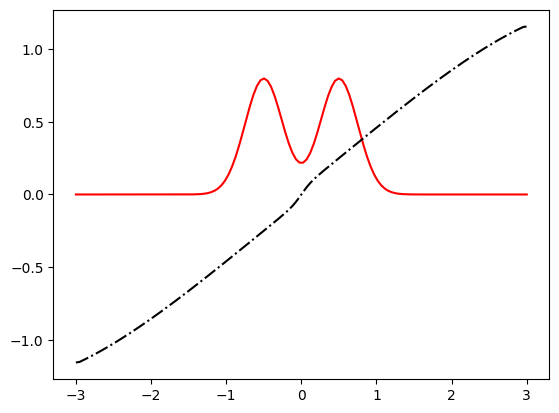

t = 0.000 , int f db = 1.000 



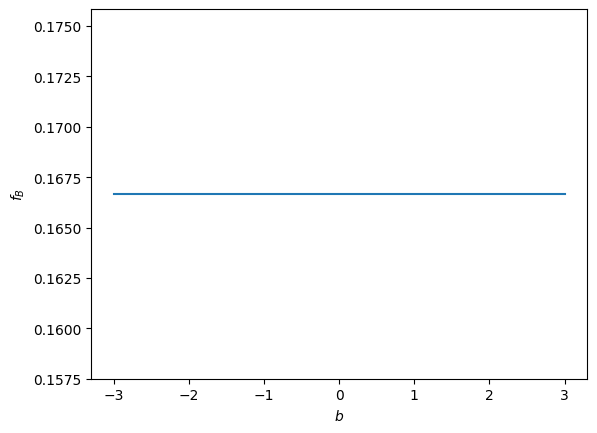

t = 10.001 , int f db = 1.033 



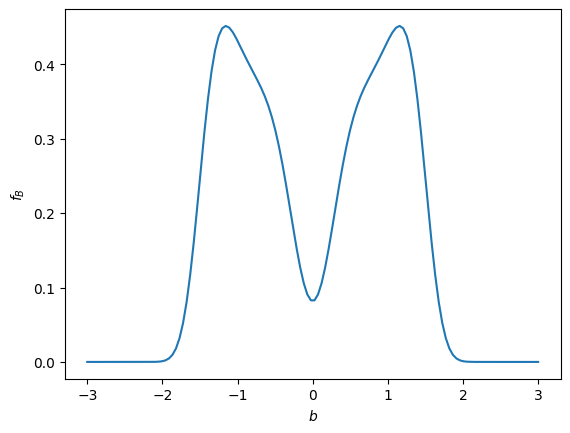

t = 20.002 , int f db = 1.033 



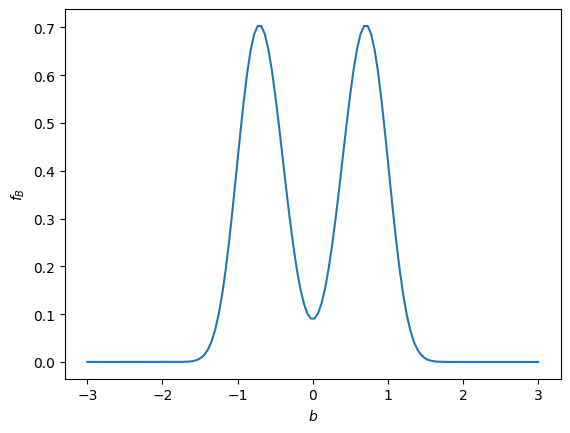

t = 30.003 , int f db = 1.033 



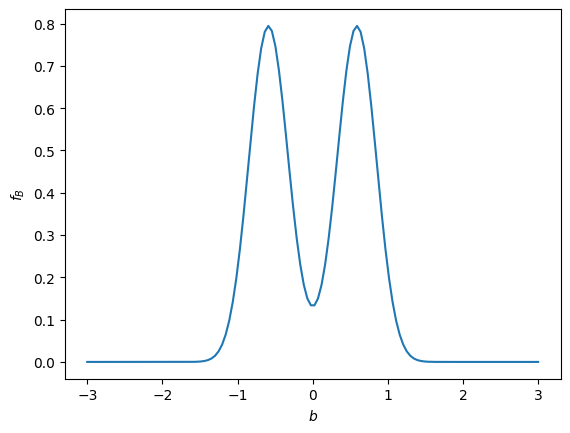

t = 40.004 , int f db = 1.033 



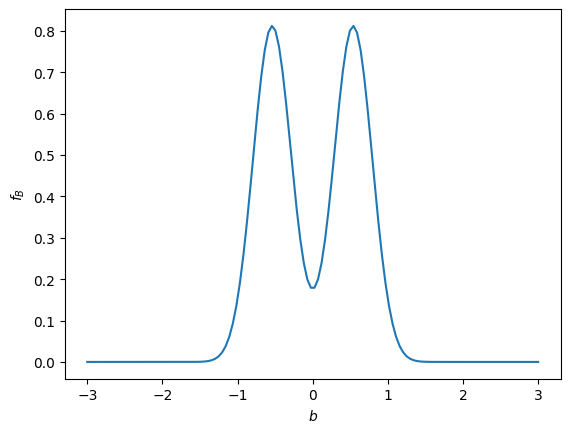

t = 50.005 , int f db = 1.033 



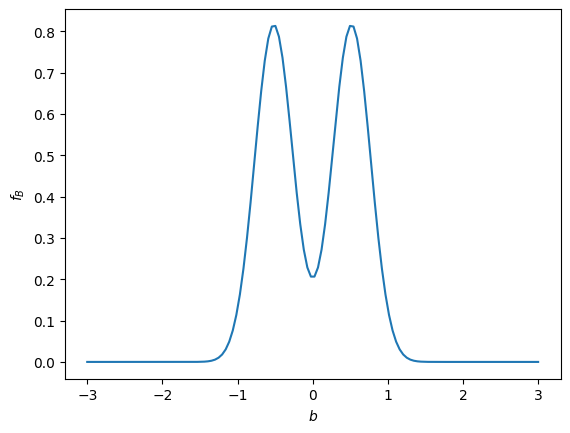

t = 60.006 , int f db = 1.033 



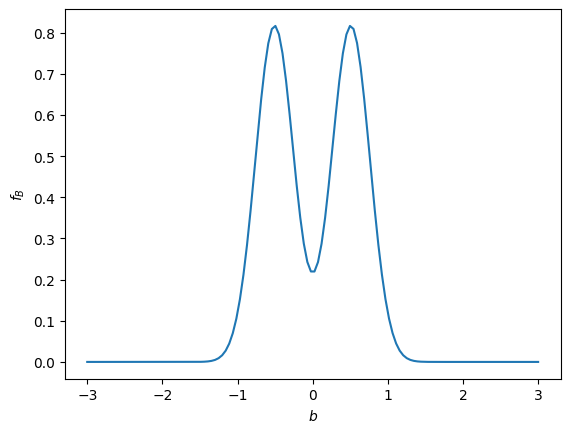

t = 70.007 , int f db = 1.033 



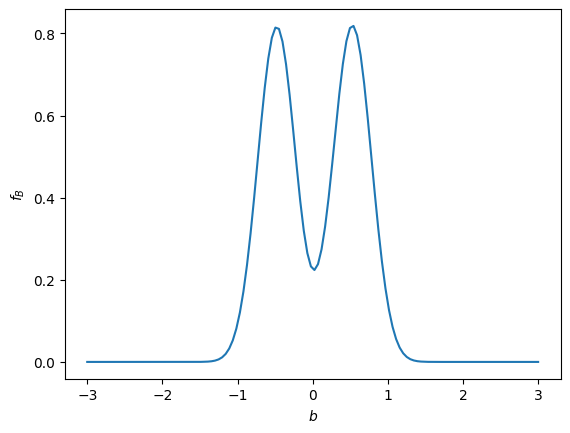

t = 80.008 , int f db = 0.724 



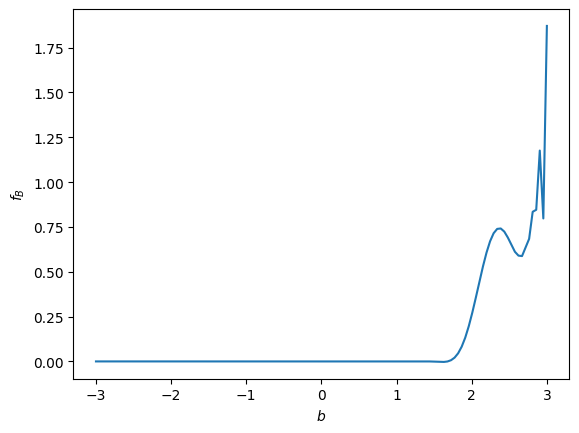

t = 90.009 , int f db = 0.234 



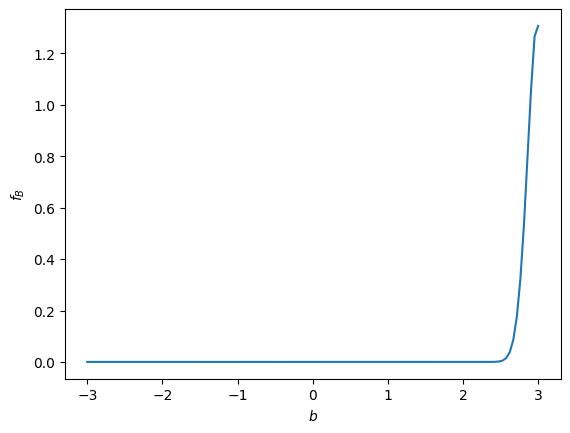

In [16]:
# Location of 'interface(s)'
loc = [-.5, .5]  # Mean/height of the layer
std = [0.25, 0.25]  # Standard deviation of the layer
amp = [1, 1]  # Changes the maximum and minimum buoyancy of the layer

# Enforce normalisation
SUM = np.sum(amp)
amp = [i/SUM for i in amp]

D1f,f = forcing(loc, std, amp, b)
D1 = D1f/f
#plt.plot(b,D1,'b:')
plt.plot(b,f ,'r-')

plt.plot(b,D1,'k-.')
plt.show()

N_T = 10**4
T, Δt = np.linspace(0,100,N_T,retstep=True)

# Uniform Initial conditions for f
f = np.ones(N_b)/(b[-1] - b[0])

# Solve
solver_forced(f, b, T, Δt, D1)